## Imports

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Preparación de la imagen

Se preparó la imagen aplicándole un suavizado gaussiano para eliminar ruido.
Adicionalemnte, dado que sólo nos interesan los bloques, se recortó la imagen para eliminar informacióin innecesaria que puee generar resultados erróneos (este podría ser un paso de calibración que se haría periódicamente para asegurarse que el recorte de la imagen contenga siempre en el área de trabajo).

CROPPED IMAGE:


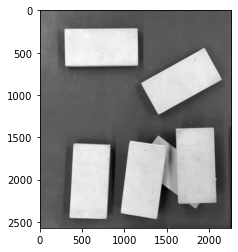

In [2]:
original_image = cv.imread("bloques1.jpg")
cropped_image = original_image[730:3300,240:2500]
grayscale_image = cv.cvtColor(cropped_image, cv.COLOR_BGR2GRAY)
blurred_image = cv.GaussianBlur(grayscale_image, (19,19),0)
print("CROPPED IMAGE:")

plt.figure("CROPPED")

plt.imshow(blurred_image, cmap='gray')
plt.show()

## Prueba de operaciones morfológicas

Se realizó la binarización por el método e **Otzu** y se realizaron pruebas con las distintas operaciones morfológicas vistas en clase (**erosión**, **dilatación**, **apertura**, **cierre**, y **apertura + cierre**) para determinar cual es la que mejor se ajusta a nuestro caso.

BINARIZED:


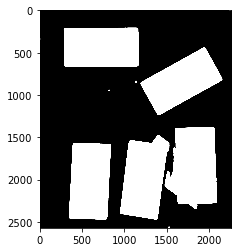

ERODE:


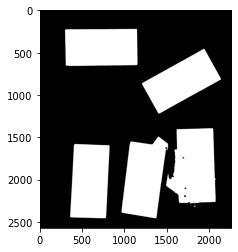

DILATE:


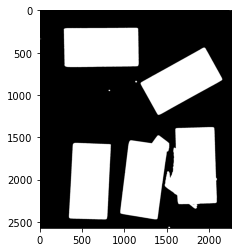

OPEN:


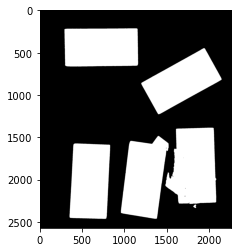

CLOSE:


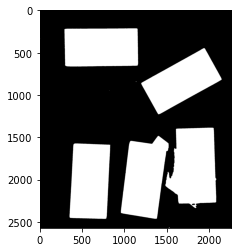

OPEN + CLOSE:


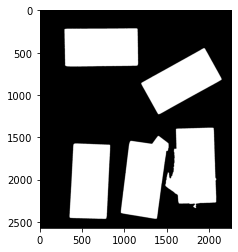

In [3]:
otsu_binarized_image = cv.threshold(blurred_image, 120, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
print("BINARIZED:")
plt.imshow(otsu_binarized_image, cmap='gray', vmin=0, vmax=1)
plt.show()

structuring_element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (15,15))

eroded_image = cv.erode(otsu_binarized_image, structuring_element, iterations = 1)
print("ERODE:")
plt.imshow(eroded_image, cmap='gray')
plt.show()

dilated_image = cv.dilate(otsu_binarized_image, structuring_element, iterations = 1)
print("DILATE:")
plt.imshow(dilated_image, cmap='gray')
plt.show()

opened_image = cv.morphologyEx(otsu_binarized_image, cv.MORPH_OPEN, structuring_element)
print("OPEN:")
plt.imshow(opened_image, cmap='gray')
plt.show()


closed_image = cv.morphologyEx(otsu_binarized_image, cv.MORPH_CLOSE, structuring_element)
print("CLOSE:")
plt.imshow(closed_image, cmap='gray')
plt.show()

open_closed_image = cv.morphologyEx(otsu_binarized_image, cv.MORPH_OPEN, structuring_element)
open_closed_image = cv.morphologyEx(open_closed_image, cv.MORPH_CLOSE, structuring_element)
print("OPEN + CLOSE:")
plt.imshow(open_closed_image, cmap='gray')
plt.show()


Se verifica que se obtuvo el mejor resultado con **apertura + cierre**.

## Contornos
Se obtuvieron los contornos de la imagen procesada.

CONTOURS:


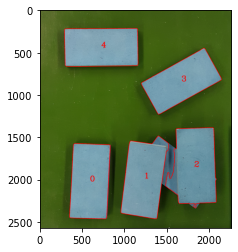

In [4]:
def draw_contours(image, contours):
    cv.drawContours(image, contours, -1, (255,0,0), 5)
    for index in range(len(contours)):
        moment = cv.moments(contours[index])
        cv.putText(image, str(index),
                   (int(moment['m10']/moment['m00']), int(moment['m01']/moment['m00'])),
                   cv.FONT_HERSHEY_COMPLEX, 3, (255,0,0), 5)
    print("CONTOURS:")
    plt.imshow(image)
    plt.show()

contours = cv.findContours(open_closed_image, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[0]

draw_contours(cropped_image.copy(), contours)


## Operaciones
Se realizaron las operaciones solicitadas en el enunciado, **área**, **perímetro**, **orientación** y **relación de aspecto**.

In [5]:
def calculate_aspect_ratio(contour):
    min_area_rect = cv.minAreaRect(contour)
    width,height = min_area_rect[1]
    if (width > height):
        return float(height)/width
    else:
        return float(width)/height
    # min_area_rect = cv.minAreaRect(contour)
    # box = cv.boxPoints(min_area_rect)
    # box = np.int0(box)
    # x,y,w,h = cv.boundingRect(contour)


for index in range(len(contours)):
    contour = contours[index]
    print("CONTOUR INDEX {}".format(index))
    print("AREA: {}".format(cv.contourArea(contour)))
    print("PERIMETER: {}".format(cv.arcLength(contour, True)))
    print("ANGLE: {}".format(cv.fitEllipse(contour)[2]))
    print("ASPECT RATIO: {}".format(calculate_aspect_ratio(contour)))
    print("\n")


CONTOUR INDEX 0
AREA: 381249.0
PERIMETER: 2648.132030725479
ANGLE: 3.3308162689208984
ASPECT RATIO: 0.4957250052649757


CONTOUR INDEX 1
AREA: 391873.0
PERIMETER: 2845.734185695648
ANGLE: 8.699400901794434
ASPECT RATIO: 0.47888232152851073


CONTOUR INDEX 2
AREA: 431431.0
PERIMETER: 3135.5087900161743
ANGLE: 1.5179578065872192
ASPECT RATIO: 0.6386399982644448


CONTOUR INDEX 3
AREA: 365159.5
PERIMETER: 2731.58315718174
ANGLE: 60.93071746826172
ASPECT RATIO: 0.5001472059123977


CONTOUR INDEX 4
AREA: 380134.0
PERIMETER: 2607.9066350460052
ANGLE: 89.68225860595703
ASPECT RATIO: 0.5182935058038483




## Conclusiones
Se observa que como en el trabajo práctico anterior, no se pudo separar correctamente los bloques apilados pero esta técnica funciona bien cuando los bloques están separados.

Esto se observa en la imagen y en las áreas, perímetros y aspect ratios:
- Los valores de los bloques **0**, **3** y **4** son muy similares entre si.
- En el bloque **2** se observa que esos valores son bastante distintos a los anteriores debido a que toma gran parte del bloque que tiene abajo.
- Para el bloque **1**, estos valores son bastante parecidos a los de los bloques **0**, **3** y **4** con lo cual podría dar un falso positivo.

Depende de la aplicación, tal vez sea conveniente ajustar el proceso para que tome los bloques apilados como un solo bloque.